In [201]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from skimage import morphology
from scipy import ndimage
import cv2
import skimage
#from functools import reduce
#from sklearn.feature_extraction import image

In [23]:
images = np.load('train_images.npy',  encoding='latin1')

In [24]:
extract = []
for i in range(len(images)):
    extract.append(images[i][1].reshape(100, 100))

In [25]:
extract_arr = np.array(extract)

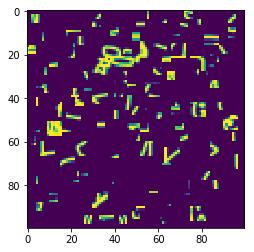

In [38]:
plt.imshow(extract_arr[2])

In [4]:
# defining global variable path
# Location of my dataset on My Google Drive
image_path = "./"
# import tensorflow as tf

def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, 'train', file)
                          for file in os.listdir(path + "/train")
                          if file.endswith('.png')])
    return image_files

In [5]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()



In [268]:
# Preprocessing
def processing(data):
    for k in range(len(data)):
        # Reading 3 images to work
        img = [cv2.imread(i, 0) for i in data]
#         print("first line: ", type(img[0]))
    #     img = data[:3]
        try:
            print('Original size',img[0].shape)
        except AttributeError:
            print("shape not found")

        # --------------------------------
        # setting dim of the resize
        height = 220
        width = 220
        dim = (width, height)
        res_img = []
        for i in range(len(img)):
            res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
            res_img.append(res)

        # Checcking the size
        try:
            print('RESIZED', res_img[k].shape)
        except AttributeError:
            print("shape not found")


        # Visualizing one of the images in the array
        original = res_img[k]
        display_one(original)
        # ----------------------------------
        # Remove noise
        # Using Gaussian Blur
        no_noise = []
        for i in range(len(res_img)):
            blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
            no_noise.append(blur)


        image = no_noise[k]
        display(original, image, 'Original', 'Blured')
        #---------------------------------
        # Segmentation
#         gray = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        gray = image
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Displaying segmented images
        display(original, thresh, 'Original', 'Segmented')
        # Further noise removal (Morphology)
#         kernel = np.ones((3, 3), np.uint8)
#         kernel = np.array([[0, 0, 1, 0, 0],
#                            [0, 1, 1, 1, 0],
#                            [1, 1, 1, 1, 1],
#                            [0, 1, 1, 1, 0],
#                            [0, 0, 1, 0, 0]], np.uint8)
#         kernel = morphology.star(1)
#         kernel = morphology.octagon(3, 1)
#         kernel = morphology.ball(2)
#         kernel = morphology.octahedron(2)
        kernel = morphology.square(3)
        
#         opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#         opening = morphology.black_tophat(thresh)

        # sure background area
#         sure_bg = cv2.dilate(opening, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=2)

        # Finding sure foreground area
#         dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#         ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        #Displaying segmented back ground
        display(original, sure_bg, 'Original', 'Segmented Background')

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1

#         # Now, mark the region of unknown with zero
        markers[unknown == 255] = 0
        
#         image.convertTo(dst, CV_32SC1)
#         print(image.type())
#         h, w = image.shape
#         print(image.dtype)

        image.astype(np.uint8)
        markers = cv2.watershed(image, markers)
        image[markers == -1] = [255, 0, 0]

        # Displaying markers on the image
        display(original, markers, 'Original', 'Marked')

number of FILES in dir 3
--------------------------------
List of files the first 3 in the folder:
 ['./train/11.png', './train/12.png', './train/2.png']
--------------------------------
Original size (219, 218)
RESIZED (220, 220)


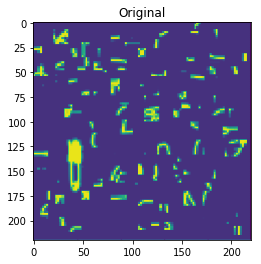

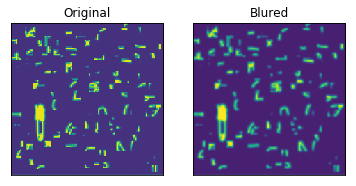

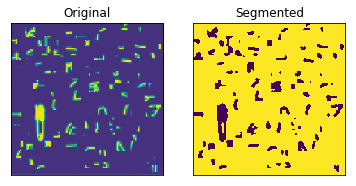

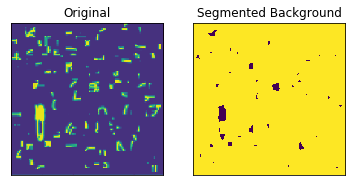

error: OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [269]:
def main():
    # calling global variable
    global image_path
    '''The var Dataset is a list with all images in the folder '''
    dataset = loadImages(image_path)
    print('number of FILES in dir', len(dataset))
    print("--------------------------------")
    #print(cv2.imread(dataset[0]).shape)
    print("List of files the first 3 in the folder:\n",dataset[:3])
    print("--------------------------------")
    
    # sending all the images to pre-processing
    processing(dataset)
   
    #list files in directory
    #a = tf.gfile.ListDirectory('drive/My Drive/BiSeNet/dataset/train')
    #print(a)
  
main()